# Determining Sigma 10 & R 10 of DESIJ0201-2739

Author: Md Mamun Hossain Nahid, Anowar Shajib, S M Rafee Adnan \\
Acknowledgement: Rajit

## Load data

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from google.colab import drive
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data, header = fits.getdata("DESIJ1501+5208_F140W_drz_sci.fits", header=True)

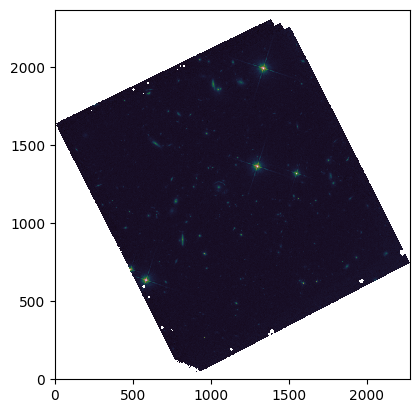

In [5]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [6]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

<ipython-input-7-eab7ae52f2d2>:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


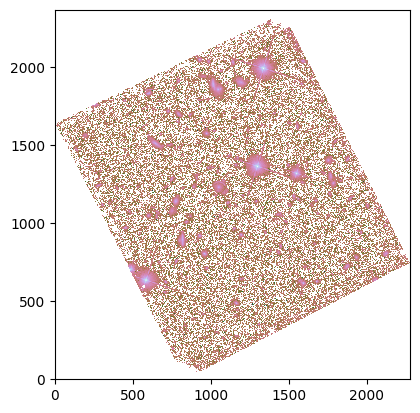

In [7]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [8]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.24040556699601626, 0.014961390589020055)

In [9]:
bkg_subtracted_data = data - bkg.background

In [10]:
threshold = 5 * bkg.background_rms

In [11]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [12]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [13]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2371, 2279)
nlabels: 560
labels: [  1   2   3   4   5 ... 556 557 558 559 560]


In [14]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 560
labels: [  1   2   3   4   5 ... 556 557 558 559 560]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [47]:
set_x_lim1, set_x_lim2 = 900 + 20, 1100 + 70
set_y_lim1, set_y_lim2 = 1000 + 70, 1300 + 80

<ipython-input-48-45ed3ce12d25>:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


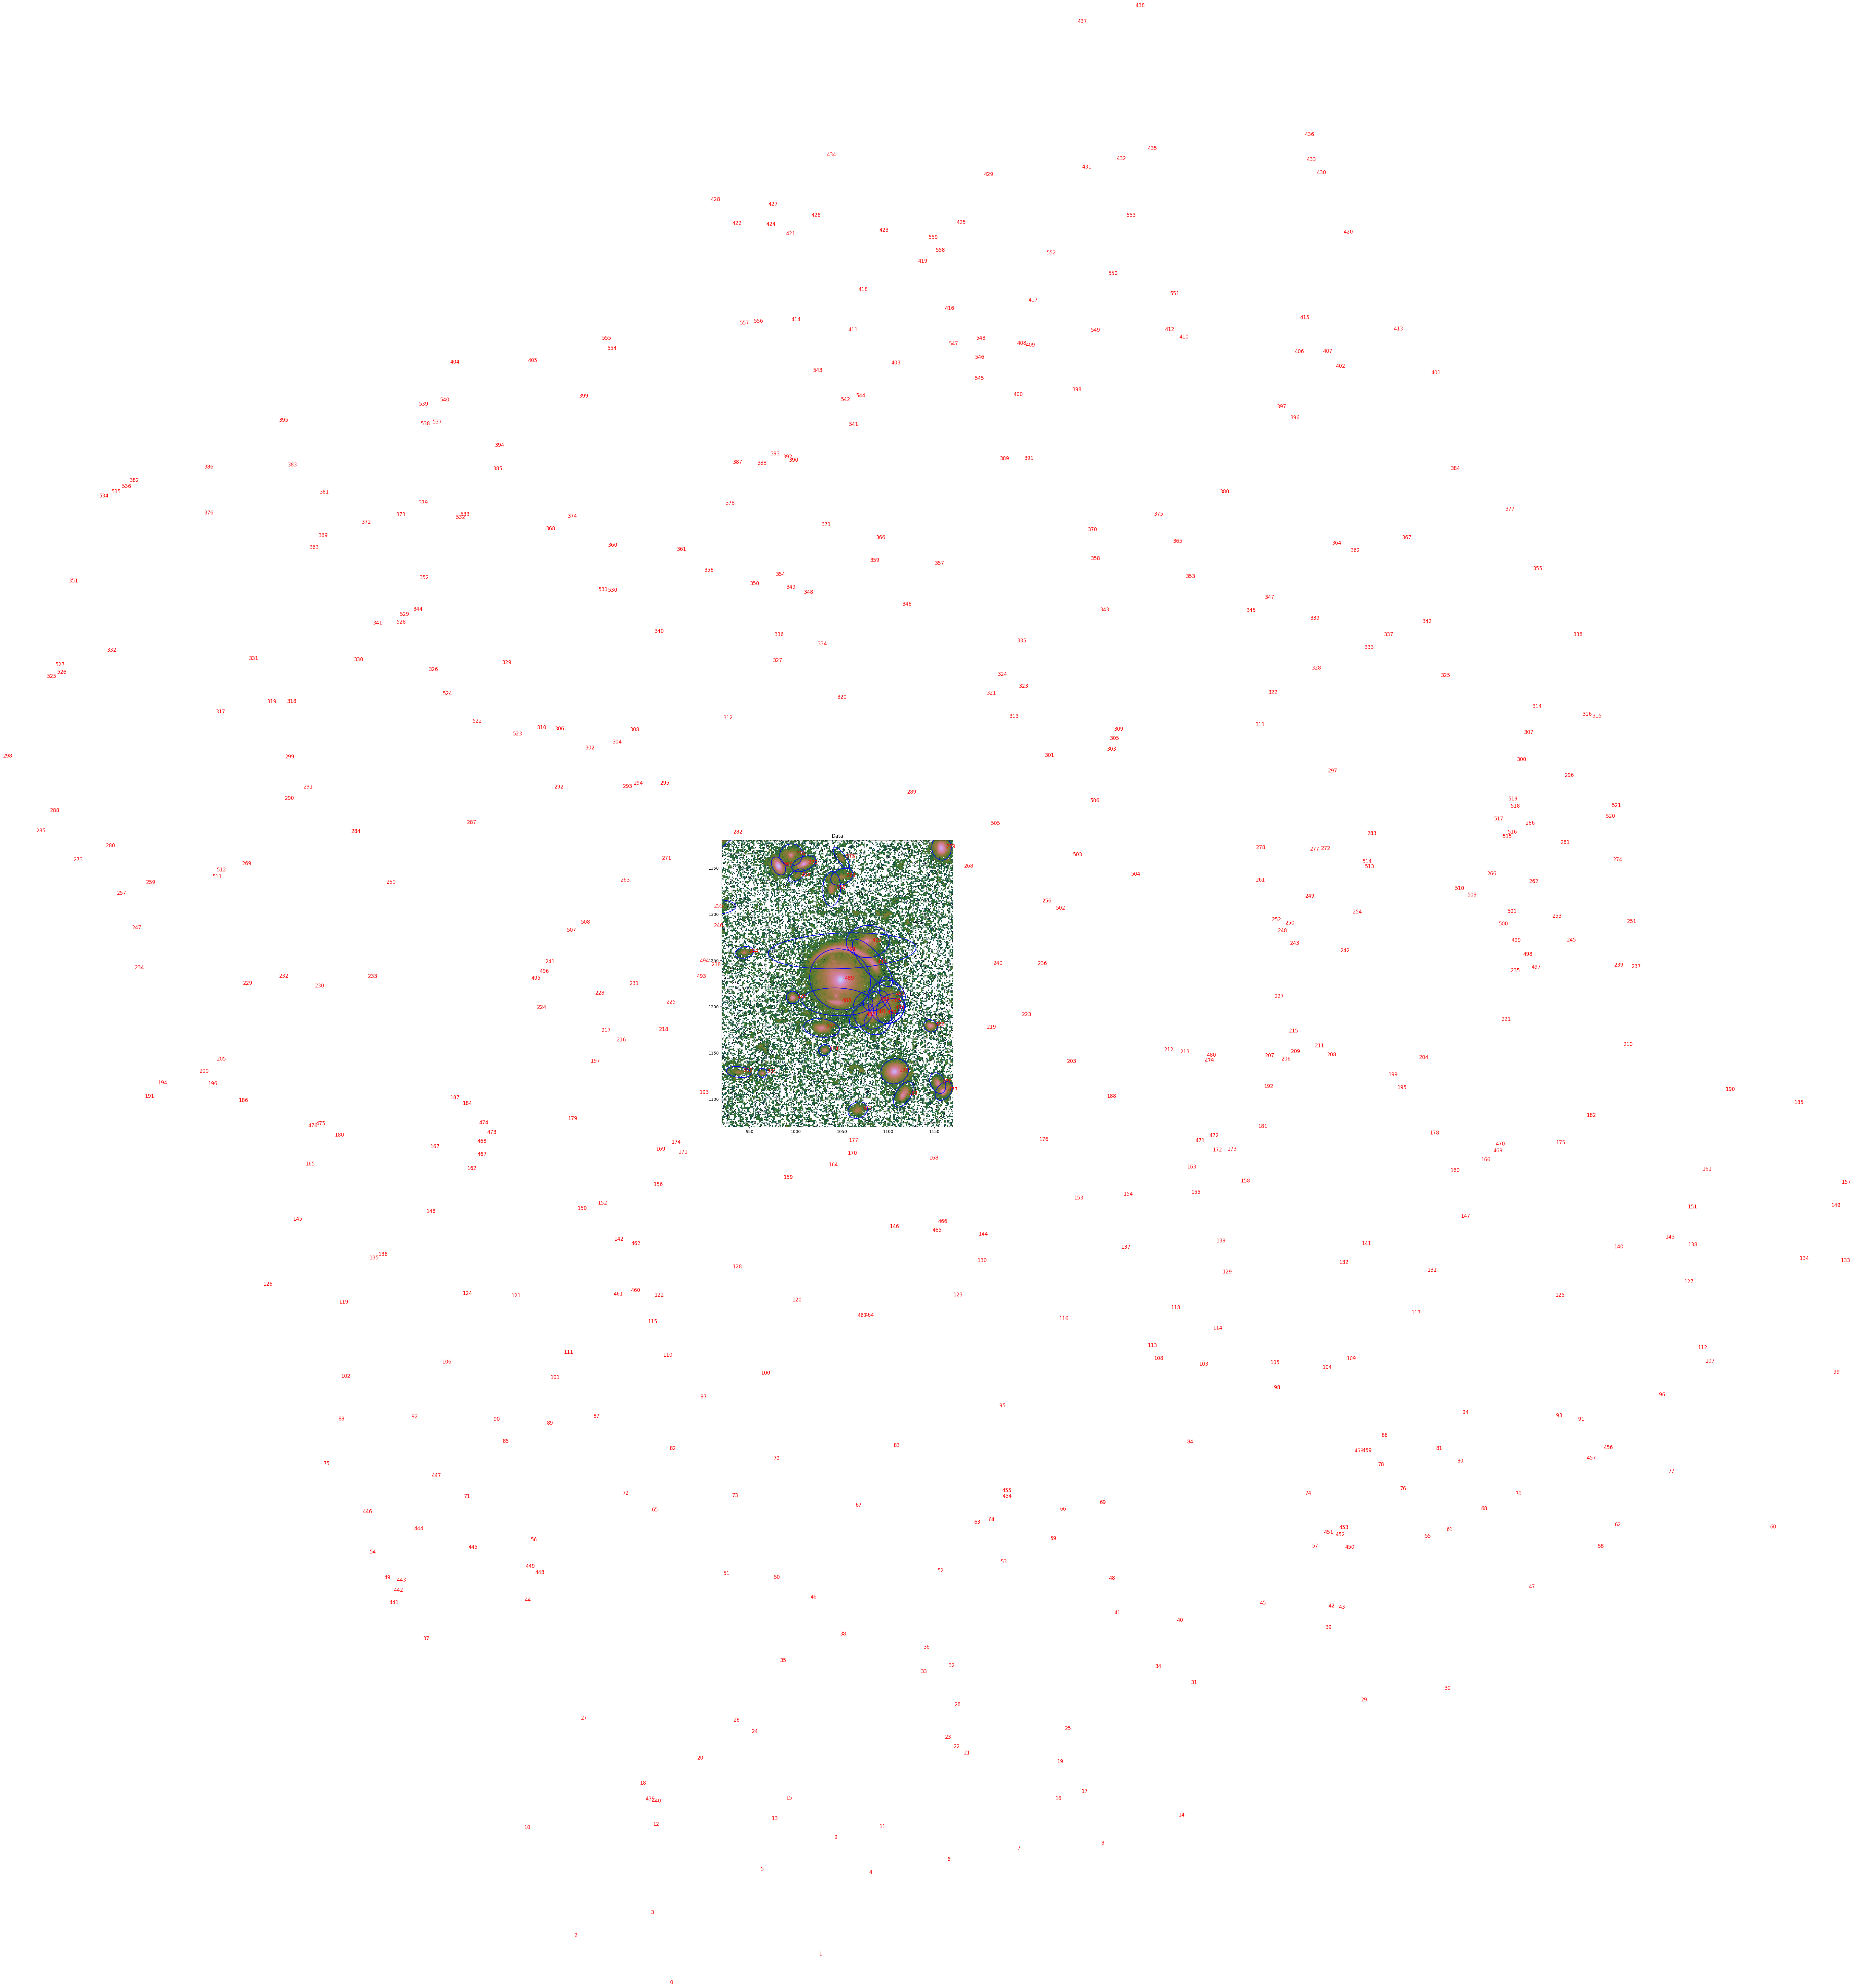

In [48]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

<ipython-input-49-83c83d63a62d>:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


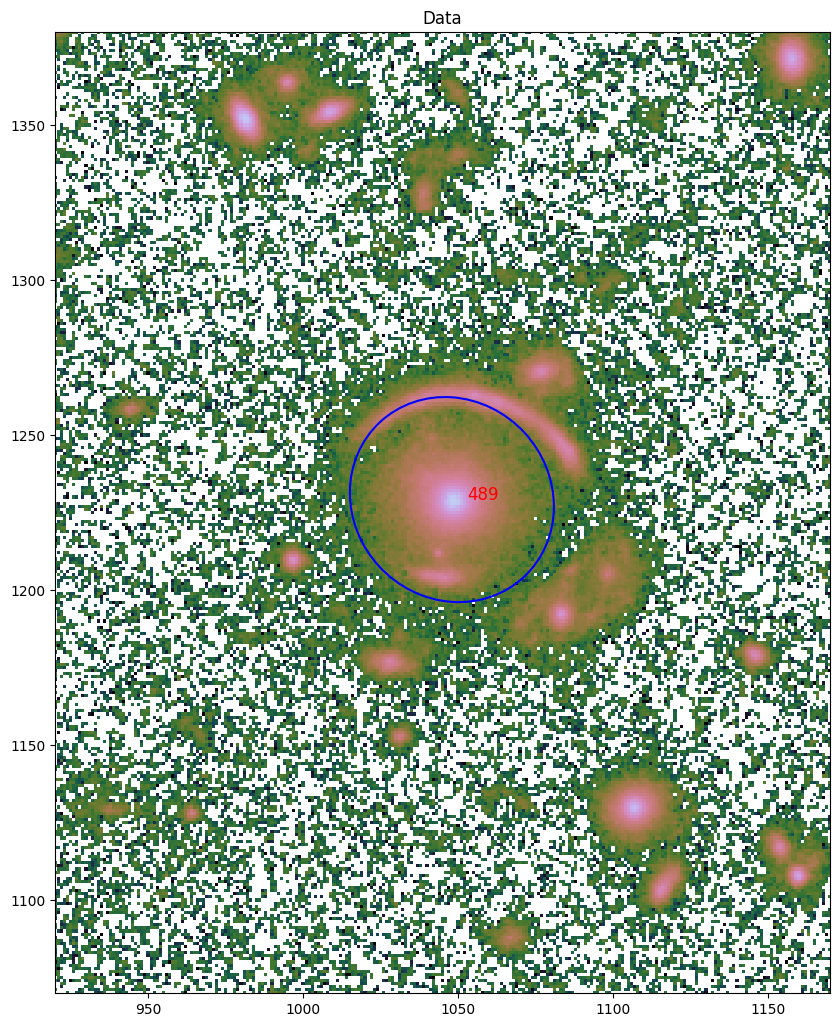

In [49]:
# object id of your central deflector/lens
id_central = 489

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [50]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [51]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of All Close galaxies:", len(close_galaxies_all))

Number of All Close galaxies: 57


In [52]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of Close galaxies excluding dim sources:", len(close_galaxies_1))

Number of Close galaxies excluding dim sources: 48


In [53]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [54]:
remove_list = [
    489,
    488,
    490,
    491,
]  # list of galaxies you want removed

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
486         45.001450          3.600116   15.407510    0.672987
482         45.615668          3.649253   15.260081    0.604736
481         50.186709          4.014937   70.457728    0.822319
492         50.642699          4.051416   52.170022    0.745368
226         54.732059          4.378565   14.892084    0.951559
485         56.197812          4.495825   41.197014    0.877142
220         56.309813          4.504785   28.401319    0.511766
487         57.768793          4.621503   17.090971    0.513907
483         59.120724          4.729658   24.602748    0.476346
484         63.141235          5.051299   16.816095    0.801806
214         78.280889          6.262471    5.714636    0.880292
258         98.315929          7.865274   14.992583    0.510125
244        107.639231          8.611138    6.278169    0.598903
222        109.990071          8.799206   14.544837    0.862304
264        110.963837          8.877107 

In [55]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
486         45.001450          3.600116   15.407510    0.672987
482         45.615668          3.649253   15.260081    0.604736
481         50.186709          4.014937   70.457728    0.822319
492         50.642699          4.051416   52.170022    0.745368
226         54.732059          4.378565   14.892084    0.951559
485         56.197812          4.495825   41.197014    0.877142
220         56.309813          4.504785   28.401319    0.511766
487         57.768793          4.621503   17.090971    0.513907
483         59.120724          4.729658   24.602748    0.476346
484         63.141235          5.051299   16.816095    0.801806
214         78.280889          6.262471    5.714636    0.880292
258         98.315929          7.865274   14.992583    0.510125
244        107.639231          8.611138    6.278169    0.598903
222        109.990071          8.799206   14.544837    0.862304
264        110.963837          8.877107 

## Determining Sigma 10, 20 and R 10, 20

<ipython-input-64-052bcf243043>:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-64-052bcf243043>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-64-052bcf243043>:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-64-052bcf243043>:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 5.051298790103563
R 20: 11.419908253630325
Sigma 10: 0.12475099285623654
Sigma 20: 0.048815179799807845

FOR All SOURCES
R 10: 5.051298790103563
R 20: 10.519646783390323
Sigma 10: 0.12475099285623654
Sigma 20: 0.05752780548904084


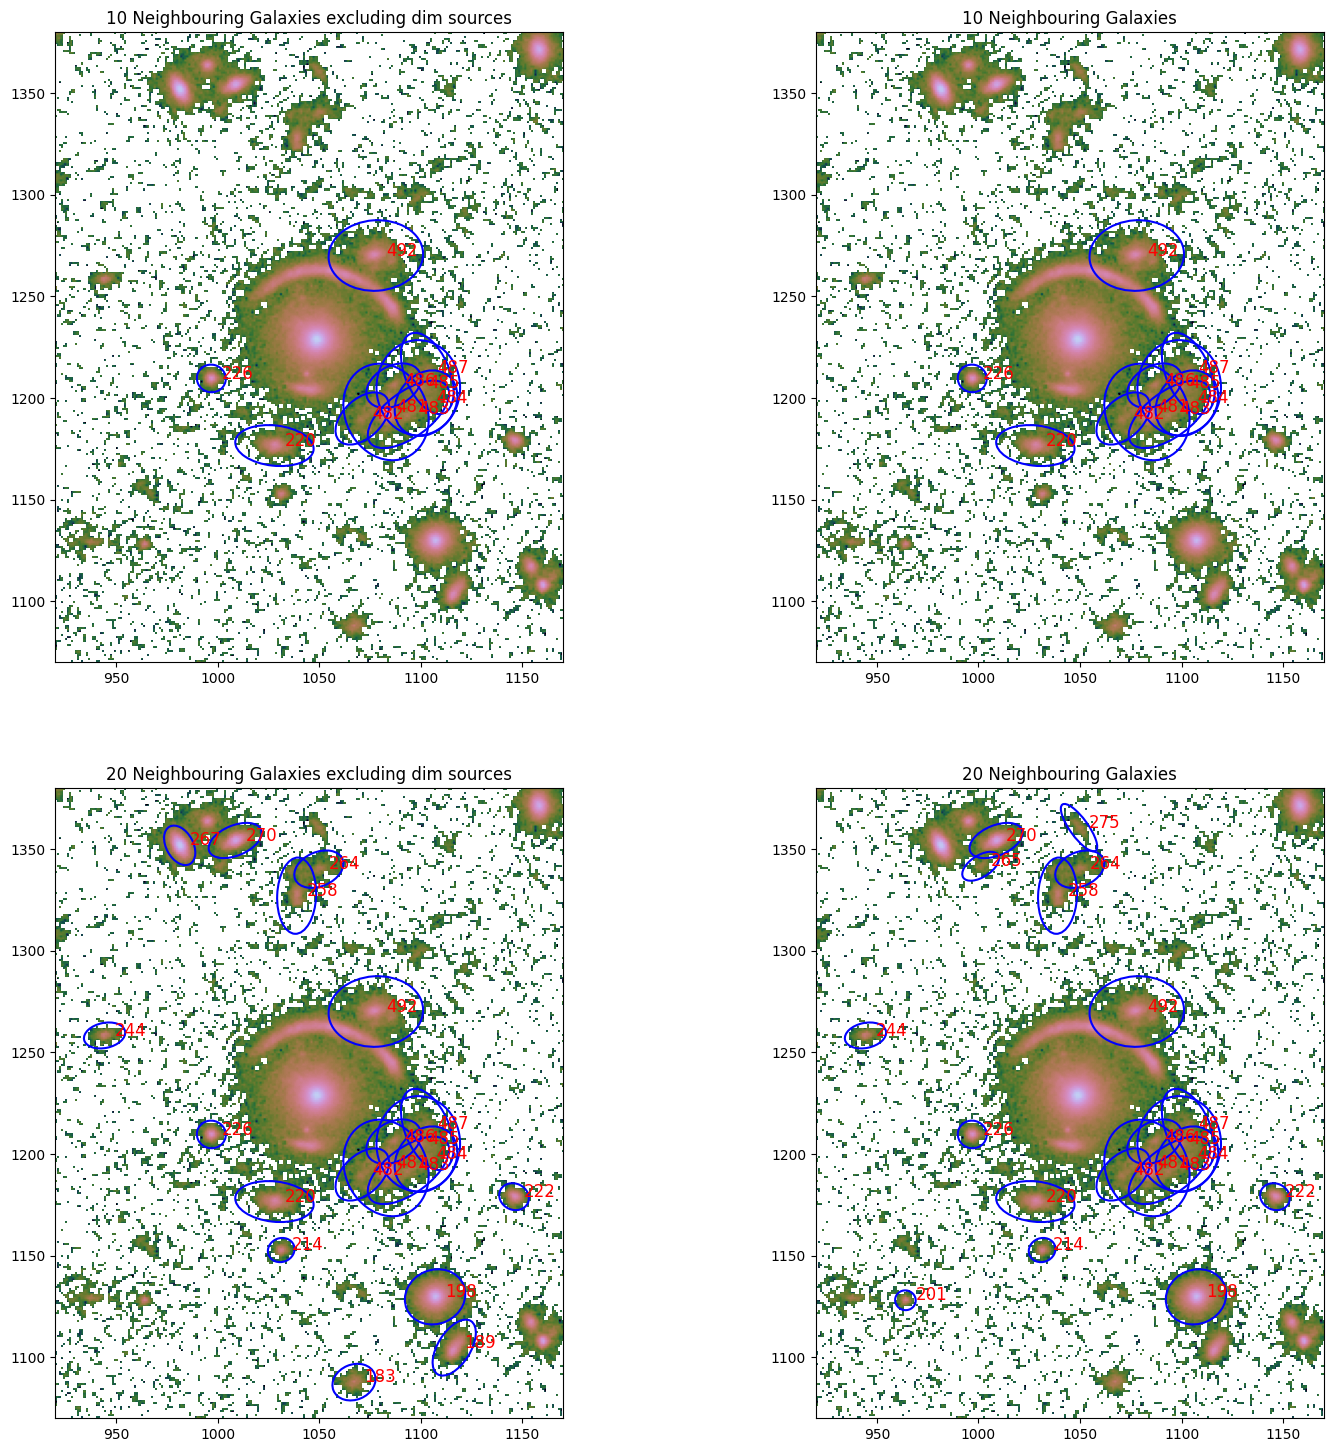

In [64]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(18, 18))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

### Store the Σ_10, Σ_10 flux selected,, Σ_20, Σ_20 flux selected values in the YAML file

In [65]:
# convert the numpy.float64 values to floats

Sigma_10_all = Sigma_10_all.item()
Sigma_10_1 = Sigma_10_1.item()
Sigma_20_all = Sigma_20_all.item()
Sigma_20_1 = Sigma_20_1.item()

In [60]:
# Existing YAML file with other parameters


existing_yaml_file = "DESIJ1501+5208_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10": Sigma_10_all,
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20": Sigma_20_all,
    "Sigma_20_flux_selected": Sigma_20_1,
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [61]:
# Read the YAML file using safe_load

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7205276678934682, 'Sigma_10': 0.12475099285623654, 'Sigma_10_flux_selected': 0.12475099285623654, 'Sigma_20': 0.05752780548904084, 'Sigma_20_flux_selected': 0.048815179799807845, 'center_x_light': [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784], 'center_x_mass': [0.033130305488043604, 0.007384661707673372, 0.006157518127173991], 'center_y_light': [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254], 'center_y_mass': [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092], 'gamma': [2.083668899427006, 0.02954313270701414, 0.02798070831466548], 'gamma_shear': [0.08959315646736743, 0.008541760945411647, 0.010914588338414091], 'phi_light': [0.46842463940573453, 0.06289781186294596, 0.059081412846965775], 'phi_mass': [-0.07062089119783126, 0.037553713585279924, 0.04068001166678517], 'phi_shear': [0.1474132813237036, 0.007024418601559668, 0.008842644855025089], 'q_light': [0.9533601976138689, 0.004